## Calculating return period for cyclones in Madagascar



We're looking to calculate the return period for cyclones of a given threshold speed over select provinces in Madagascar. We'd like to have both: 
- An overall return period across the country

In [7]:
%load_ext jupyter_black
%load_ext autoreload
%autoreload 2

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
import geopandas as gpd
import pandas as pd
from pathlib import Path
from shapely.geometry import LineString
import os
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np

In [12]:
AA_DATA_DIR = os.getenv("AA_DATA_DIR")

## Data loading and preparation

https://en.wikipedia.org/wiki/Tropical_cyclone_scales#South-West_Indian_Ocean


In [13]:
adm0_path = (
    Path(AA_DATA_DIR)
    / "public"
    / "raw"
    / "mdg"
    / "cod_ab"
    / "mdg_admbnda_adm0_BNGRC_OCHA_20181031.shp"
)
gdf_adm0 = gpd.read_file(adm0_path)

ibtracs_path = adm1_path = Path(AA_DATA_DIR) / "public" / "raw" / "glb" / "ibtracs"
points_path = Path(
    ibtracs_path / "IBTrACS.SI.list.v04r01.points/IBTrACS.SI.list.v04r01.points.shp"
)
lines_path = Path(
    ibtracs_path / "IBTrACS.SI.list.v04r01.lines/IBTrACS.SI.list.v04r01.lines.shp"
)

gdf_points = gpd.read_file(points_path)
gdf_lines = gpd.read_file(lines_path)

In [14]:
gdf_points_sel = gpd.sjoin(gdf_points, gdf_adm0, how="inner", predicate="intersects")
gdf_lines_sel = gpd.sjoin(gdf_lines, gdf_adm0, how="inner", predicate="intersects")
gdf_points_sel_ = gdf_points_sel.sort_values("ISO_TIME")

<Axes: >

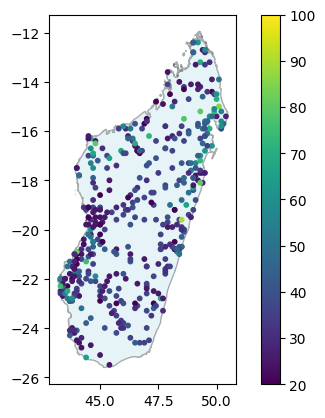

In [15]:
ax = gdf_adm0.plot(color="lightblue", edgecolor="black", alpha=0.3)
gdf_points_sel_.plot(ax=ax, column="REU_WIND", markersize=10, legend=True)

## Return period calculation


In [17]:
# combining US Wind and REUnion for those with no wind speed
gdf_points_sel_["REU_USA_WIND"] = gdf_points_sel_["REU_WIND"].fillna(
    gdf_points_sel_["USA_WIND"] * 0.88
)

In [18]:
df = gdf_points_sel_[
    gdf_points_sel_["ISO_TIME"].apply(
        lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S").year
    )
    >= 1998
]
df["NAME"].unique()

array(['BELTANE', 'ASTRIDE', 'ELINE:LEONE', 'GLORIA', 'HUDAH', 'DERA',
       'CYPRIEN', 'GUILLAUME', 'KESINY', 'FARI', 'CELA', 'ELITA',
       'GAFILO', 'ERNEST', 'FELAPI', 'BOLOETSE', 'BONDO', 'CLOVIS',
       'INDLALA', 'JAYA', 'FAME', 'IVAN', 'JOKWE', 'FANELE', 'JADE',
       'FAMI', 'HUBERT', 'BINGIZA', 'CHANDA', 'GIOVANNA', 'IRINA',
       'HARUNA', 'DELIWE', 'HELLEN', 'CHEDZA', 'UNNAMED', 'ENAWO', 'AVA',
       'ELIAKIM', 'BELNA', 'DIANE', 'FRANCISCO', 'CHALANE', 'ELOISE',
       'IMAN', 'ANA', 'BATSIRAI', 'DUMAKO', 'EMNATI', 'GOMBE', 'JASMINE',
       'CHENESO', 'FREDDY', 'ALVARO', 'GAMANE'], dtype=object)

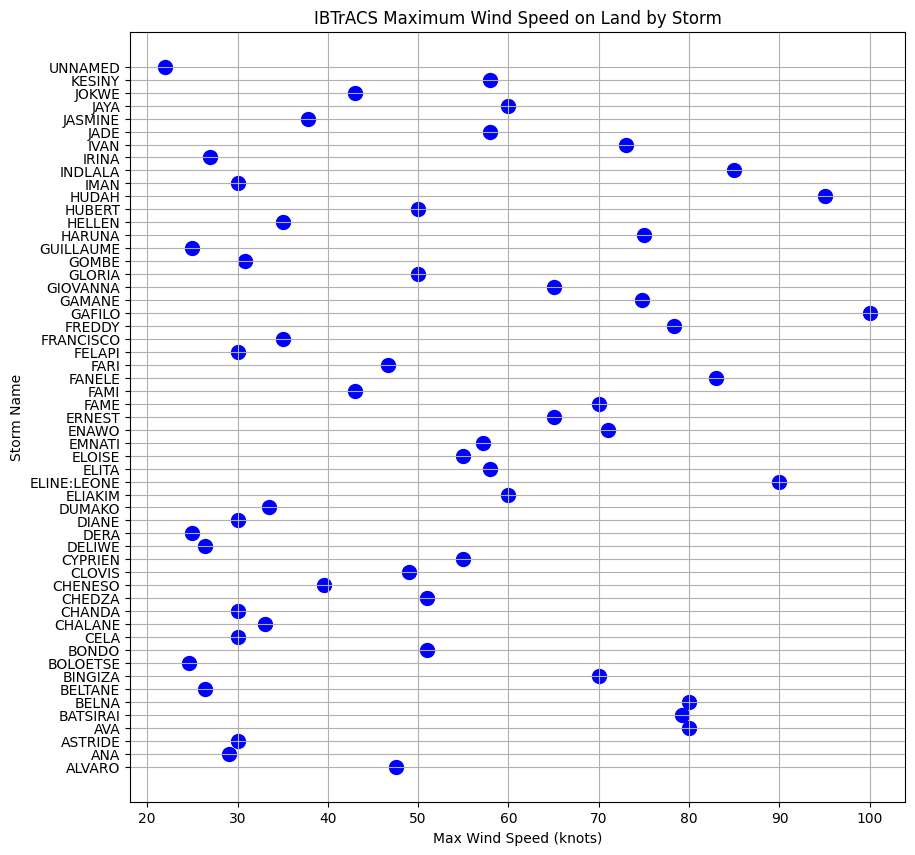

In [54]:
max_values = df.groupby("NAME")["REU_USA_WIND"].max().reset_index()

# Step 3: Plot the maximum values as points for each category
plt.figure(figsize=(10, 10))
plt.scatter(
    max_values["REU_USA_WIND"],
    max_values["NAME"],
    color="blue",
    s=100,
    label="Max Wind Speed",
)

# Adding labels and title
plt.ylabel("Storm Name")
plt.xlabel("Max Wind Speed (knots)")
plt.title("IBTrACS Maximum Wind Speed on Land by Storm")
plt.grid(True)
plt.show()

In [42]:
def calculate_storm_return_period(df, wind_speed_kmh, start_year, num_storms_year):
    # Conversion factor from kilometers per hour to knots
    kmh_to_knots = 1 / 1.852

    # Convert the given speed from km/h to knots
    speed_knots = wind_speed_kmh * kmh_to_knots

    # Extract the year from the 'ISO_TIME' column
    df["year"] = df["ISO_TIME"].apply(
        lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S").year
    )

    # Filter the DataFrame for records from the start year and with wind speed above the threshold
    df_filtered = df[(df["year"] >= start_year) & (df["REU_USA_WIND"] >= speed_knots)]

    # Count unique storms
    unique_storms = df_filtered["NAME"].nunique()

    # Calculate the total number of years in the filtered DataFrame
    yr_len = 2022 - start_year + 1

    # Calculate the combined return period
    combined_return_period = yr_len / unique_storms

    print(
        f"The combined return period of storms over {wind_speed_kmh}km/h is 1-in-{round(combined_return_period, 1)} years."
    )

In [43]:
calculate_storm_return_period(
    df=gdf_points_sel_,
    wind_speed_kmh=118,
    start_year=1980,
    num_storms_year=1,
)

The combined return period of storms over 118km/h is 1-in-1.7 years.


In [44]:
calculate_storm_return_period(
    df=gdf_points_sel_,
    wind_speed_kmh=166,
    start_year=1980,
    num_storms_year=1,
)

The combined return period of storms over 166km/h is 1-in-6.1 years.


C:\Users\pauni\AppData\Local\Temp\ipykernel_13168\25368824.py:50: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_adm0_buffer["geometry"] = gdf_adm0.geometry.buffer(
C:\Users\pauni\AppData\Local\Temp\ipykernel_13168\25368824.py:50: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_adm0_buffer["geometry"] = gdf_adm0.geometry.buffer(
C:\Users\pauni\AppData\Local\Temp\ipykernel_13168\25368824.py:50: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_adm0_buffer["geometry"] = gdf_adm0.geometry.buffer(
C:\Users\pauni\AppData\Local\Temp\ipykernel_13168\25368824.py:50: UserWarning: 

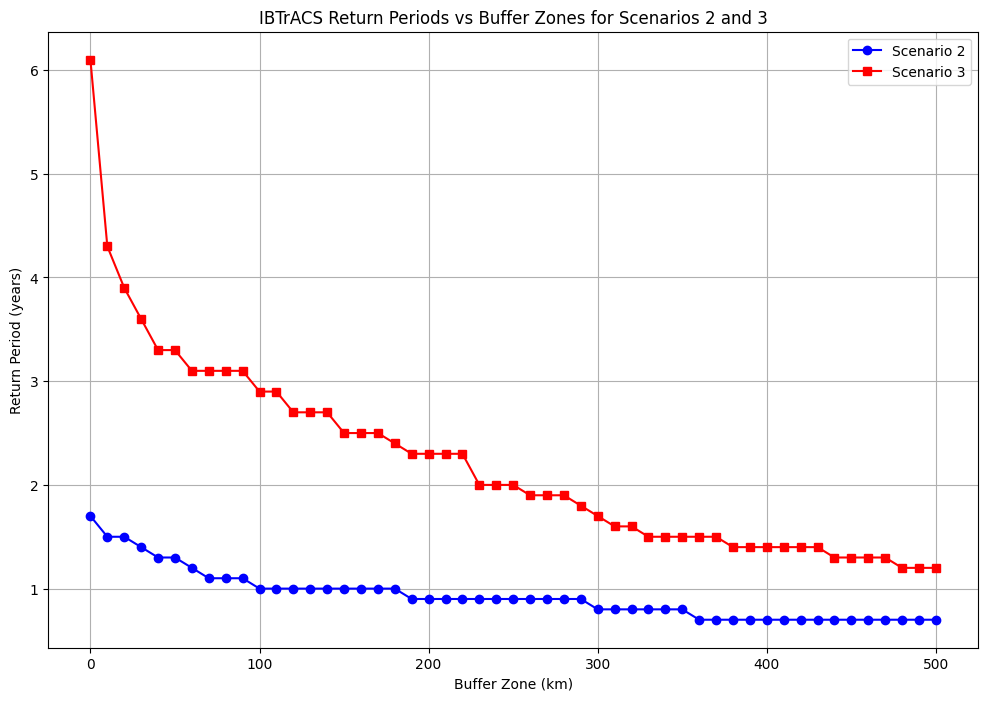

In [53]:
# Function to calculate the return period for a given wind speed threshold and buffer zone
def calculate_storm_return_period_buffer(
    df, gdf_adm0_buffer, wind_speed_kmh, start_year
):
    # Perform spatial join between storm points and buffer zone (gdf_adm0_buffer)
    df_sel = gpd.sjoin(df, gdf_adm0_buffer, how="inner", predicate="intersects")
    df_sel_ = df_sel.sort_values("ISO_TIME")

    # Combining US Wind and Reunion wind for those with no wind speed data
    df_sel_["REU_USA_WIND"] = df_sel_["REU_WIND"].fillna(df_sel_["USA_WIND"] * 0.88)

    # Conversion factor from kilometers per hour to knots
    kmh_to_knots = 1 / 1.852

    # Convert the given speed from km/h to knots
    speed_knots = wind_speed_kmh * kmh_to_knots

    # Extract the year from the 'ISO_TIME' column
    df_sel_["year"] = df_sel_["ISO_TIME"].apply(
        lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S").year
    )

    # Filter the DataFrame for records from the start year and with wind speed above the threshold
    df_filtered = df_sel_[
        (df_sel_["year"] >= start_year) & (df_sel_["REU_USA_WIND"] >= speed_knots)
    ]

    # Count unique storms
    unique_storms = df_filtered["NAME"].nunique()

    # Calculate the total number of years in the filtered DataFrame
    yr_len = 2022 - start_year + 1

    # Calculate the combined return period
    combined_return_period = yr_len / unique_storms
    return round(combined_return_period, 1)


# Sample buffers in kilometers
buffers = np.arange(0, 501, 10)

# Lists to store the return periods for 64 knots and 90 knots thresholds
return_periods_64_knots = []
return_periods_90_knots = []

# Iterate through buffers and calculate return periods for both thresholds
for buffer in buffers:
    # Create buffer around gdf_adm0 with the given distance
    gdf_adm0_buffer = gdf_adm0.copy()
    gdf_adm0_buffer["geometry"] = gdf_adm0.geometry.buffer(
        buffer / 110.574
    )  # Buffer in meters

    # Calculate return period for 64 knots threshold
    return_64_knots = calculate_storm_return_period_buffer(
        gdf_points, gdf_adm0_buffer, wind_speed_kmh=118, start_year=1980
    )  # 118.5 km/h = 64 knots

    # Calculate return period for 90 knots threshold
    return_90_knots = calculate_storm_return_period_buffer(
        gdf_points, gdf_adm0_buffer, wind_speed_kmh=166, start_year=1980
    )  # 166.7 km/h = 90 knots

    # Store the return periods
    return_periods_64_knots.append(return_64_knots)
    return_periods_90_knots.append(return_90_knots)

# Plotting the return periods for both 64 knots and 90 knots
plt.figure(figsize=(12, 8))
plt.plot(
    buffers,
    return_periods_64_knots,
    marker="o",
    label="Scenario 2",
    color="blue",
)
plt.plot(
    buffers,
    return_periods_90_knots,
    marker="s",
    label="Scenario 3",
    color="red",
)

plt.title("IBTrACS Return Periods vs Buffer Zones for Scenarios 2 and 3")
plt.xlabel("Buffer Zone (km)")
plt.ylabel("Return Period (years)")
plt.legend()
plt.grid(True)
plt.show()